#Image Classification  with Transfer Learning
<center><img src='https://miro.medium.com/max/1000/0*xNjEPIZmPvKeqss6' width="750" align="middle"> 

In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.



In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%cd /content/drive/My Drive/TransferLearning /

/content/drive/My Drive/TransferLearning 


### import pakage 

In [0]:
!pip install tensorflow-gpu==2.0.0

In [0]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf #tf 2.0.0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model 
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau

## Dataset Structure
Train: 1554 images <br>
Test: 500 images <br>
Number of classes: 20

##Image Augmentation 


<img src='https://cdn-images-1.medium.com/max/1000/1*C8hNiOqur4OJyEZmC7OnzQ.png' width=600>
 
#### 1. Dataset Generation (Run Augmentation.py )
#### 2. ImageDataGenerator (in-place or on-the-fly  augmentation)
#### 3. Combining dataset generation and in-place augmentation

In [0]:
# Create training ImageDataGenerator object
train_data_gen = ImageDataGenerator(rotation_range=50,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0.3,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode='constant',
                                    cval=0,
                                    rescale=1./255)

# Create validation and test ImageDataGenerator objects
valid_data_gen = ImageDataGenerator(rotation_range=45,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0.3,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode='constant',
                                    cval=0,
                                    rescale=1./255)

test_data_gen = ImageDataGenerator(rescale=1./255)


In [0]:
dataset_dir = '/content/drive/My Drive/TransferLearning /Dataset/'

# Batch size
Batch_size = 8
# img shape
img_h = 256
img_w = 256
#number classes
num_classes=20

classes = ['owl', # 0
            'galaxy', # 1
            'lightning', # 2
            'wine-bottle', # 3
            't-shirt', # 4
            'waterfall',# 5
            'sword', # 6
            'school-bus',# 7           
            'calculator', # 8
            'sheet-music', #9            
            'airplanes',#10      
            'lightbulb', # 11
            'skyscraper',#12    
            'mountain-bike',#13          
            'fireworks', #14        
            'computer-monitor',#15              
            'bear',# 16
            'grand-piano', # 17
            'kangaroo', # 18
            'laptop', #19
           ]

In [0]:
# Create generators to read images from dataset directory

SEED = 1234
tf.random.set_seed(SEED) 

training_dir = os.path.join(dataset_dir, 'training')
train_gen = train_data_gen.flow_from_directory(training_dir,
                                               target_size=(256, 256),
                                               batch_size=Batch_size,
                                               classes=classes,
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=SEED)  # targets are directly converted into one-hot vectors

# Validation
valid_dir = os.path.join(dataset_dir, 'validation')
valid_gen = valid_data_gen.flow_from_directory(valid_dir,
                                           target_size=(256, 256),
                                           batch_size=Batch_size, 
                                           classes=classes,
                                           class_mode='categorical',
                                           shuffle=False,
                                           seed=SEED)
# Test
test_dir = os.path.join(dataset_dir, 'test')
test_gen = test_data_gen.flow_from_directory(test_dir,
                                             target_size=(256, 256),
                                             batch_size=10, 
                                             shuffle=False,
                                             seed=SEED,
                                             class_mode=None,
                                             )




## Visualization data 

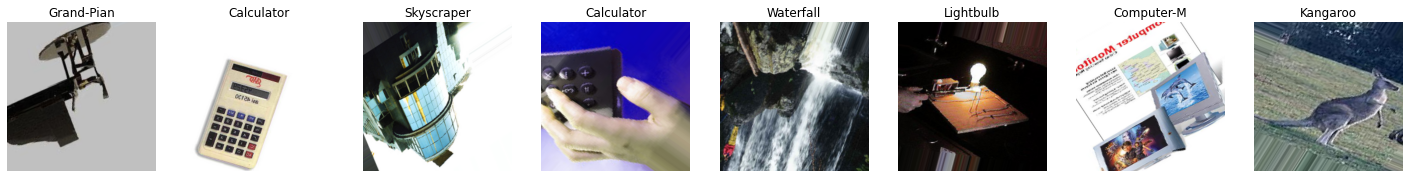

In [0]:
CLASS_NAMES = np.array(['owl','galaxy', 'lightning','wine-bottle','t-shirt','waterfall', 'sword', 'school-bus',
                        'calculator','sheet-music','airplanes', 'lightbulb', 'skyscraper','mountain-bike','fireworks', 
                        'computer-monitor','bear','grand-piano','kangaroo','laptop',], dtype='<U10')

def show_batch(image_batch, label_batch):
  plt.figure(figsize=(25,20))
  for n in range(8):
      ax = plt.subplot(1,8,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')
      
image_batch, label_batch = next(train_gen)
show_batch(image_batch, label_batch)

### ResNet152V2 (Pretrain Model) 

In [0]:
ResNet_model = tf.keras.applications.ResNet152V2(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))

In [0]:

# The last 15 layers fine tune
for layer in ResNet_model.layers[:-15]:
    layer.trainable = False

x = ResNet_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
output  = Dense(units=20, activation='softmax')(x)
model = Model(ResNet_model.input, output)


model.summary()


In [0]:
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=loss, metrics= ['accuracy'])

In [0]:
lrr = ReduceLROnPlateau(monitor='val_loss', 
                        patience=3, 
                        verbose=1, 
                        factor=0.4, 
                        min_lr=0.00001)

tensorbord = tf.keras.callbacks.TensorBoard(log_dir='./logs')

callbacks = [lrr,tensorbord]

STEP_SIZE_TRAIN=train_gen.n//train_gen.batch_size
STEP_SIZE_VALID=valid_gen.n//valid_gen.batch_size

transfer_learning_history = model.fit_generator(generator=train_gen,
                   steps_per_epoch=STEP_SIZE_TRAIN,
                   validation_data=valid_gen,
                   validation_steps=STEP_SIZE_VALID,
                   epochs=20,
                   callbacks=callbacks,
                 
                  
                    
)


Epoch 1/20
145/145 [==============================] - 147s 1s/step - loss: 1.8754 - accuracy: 0.4740 - val_loss: 3.0149 - val_accuracy: 0.5966
Epoch 2/20
145/145 [==============================] - 145s 997ms/step - loss: 1.2659 - accuracy: 0.6750 - val_loss: 2.7088 - val_accuracy: 0.6989
Epoch 3/20
145/145 [==============================] - 145s 999ms/step - loss: 1.0160 - accuracy: 0.7383 - val_loss: 1.2034 - val_accuracy: 0.7670
Epoch 4/20
145/145 [==============================] - 144s 995ms/step - loss: 0.9532 - accuracy: 0.7782 - val_loss: 1.0989 - val_accuracy: 0.7642
Epoch 5/20
145/145 [==============================] - 144s 996ms/step - loss: 0.8457 - accuracy: 0.7678 - val_loss: 1.1971 - val_accuracy: 0.7415
Epoch 6/20
145/145 [==============================] - 145s 997ms/step - loss: 0.7501 - accuracy: 0.7998 - val_loss: 0.6911 - val_accuracy: 0.8466
Epoch 7/20
145/145 [==============================] - 145s 1s/step - loss: 0.7777 - accuracy: 0.8094 - val_loss: 0.6831 - val_a

### Visualization accuracy and loss 

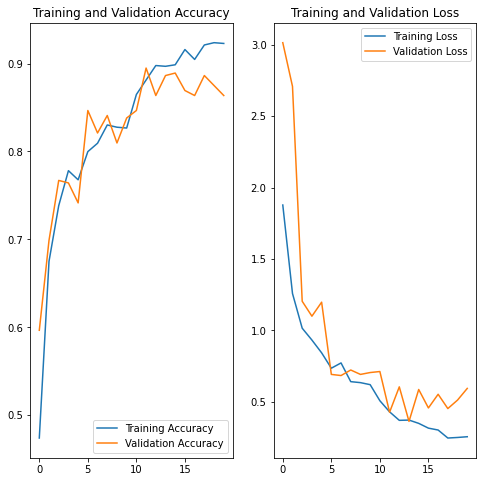

In [0]:

acc = transfer_learning_history.history['accuracy']
val_acc = transfer_learning_history.history['val_accuracy']

loss = transfer_learning_history.history['loss']
val_loss = transfer_learning_history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [0]:
%load_ext tensorboard
%tensorboard --logdir logs

### model evaluate with validation set

In [0]:
model.evaluate(valid_gen, steps=STEP_SIZE_VALID,verbose=1)

## model prediction with test data

In [0]:
STEP_SIZE_TEST=test_gen.n//test_gen.batch_size
test_gen.reset()
pred=model.predict(test_gen,
steps=STEP_SIZE_TEST,
verbose=1)

In [0]:
predicted_class_indices=np.argmax(pred,axis=1)


### CSV file for kaggle submission

In [0]:
import pandas as pd
labels = train_gen.class_indices
labels = dict((v,k) for k,v in labels.items())
predictions = [k for k in predicted_class_indices]

filenames=test_gen.filenames
FN=[]
for i in filenames:
  f = i[5:]
  FN.append(f)
  

results=pd.DataFrame({"Id":FN,
                      "Category":predictions})
results.to_csv("submission.csv",index=False)